# ***Cross-Validation.***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

In [1]:
### Paquetes a usar.
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import warnings
import statsmodels.api          as sm
##
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import LabelEncoder
from sklearn.naive_bayes        import GaussianNB, MultinomialNB
from sklearn.metrics            import roc_auc_score, accuracy_score
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import GridSearchCV
##
from sklearn.ensemble           import RandomForestClassifier
from sklearn.model_selection    import StratifiedKFold, cross_validate
##
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"

## ***Cross-Validation.***

Pensemos en la siguiente situación de la vida "real":

_Usted está estudiando para un examen y ha logrado memorizar muchos de los ejercicios que ha desarrollado como preparación, dado que usted "memorizó" (no-generalizó) seguramente en un exámen con las mismas preguntas (que usted ya "memorizó") tendrá un buen resultado. Siguiendo en la analogía, ¿cómo cree que será su calificación si el exámen tiene un grupo de preguntas que usted nunca ha estudiado? Recuerde que solo "memorizó"..._



Suponga ahora que está construyendo un modelo de `machine learning`, ¿cómo puede eliminar el problema  de "memorizar" del sistema? Intuitivamente, parece completamente lógico dejar un conjunto de datos reservados (`set_test`) que NO hará parte del entrenamiento del modelo y luego de entrenado dicho modelo aplicarlo sobre los datos reservados para ver que tan bien se comporta. En este caso, usaría la mayoría de los datos para ajustar el modelo (entrenar) y usar una porción más pequeña para probar el modelo. ¿Qué tan diferente sería la evaluación si selecciona una muestra reservada diferente?


La técnica de _**[cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)**_ amplía la idea de una muestra reservada a múltiples muestras reservas secuenciales. 

1. Reserve $1/k$ de los datos como muestra reservada.

2. Entrene el modelo con los datos restantes.

3. Aplique (score) el modelo a la reserva de $1/k$ y registre la métrica(s) de evaluación del modelo que desea.

4. Restaure el primer $1/k$ de los datos y reserve el siguiente $1/k$ (excluyendo cualquier registro que fue elegido la primera vez).

5. Repita los pasos 2 y 3.

6. Repita hasta que se haya utilizado cada registro en la parte reservada.

7. Promediar o combinar las métricas de evaluación del modelo.

La división de los datos en la muestra de entrenamiento y la muestra reservada también se denomina
un ***fold.***

Para hacer uso de esta técnica podemos usar las siguientes herramientas:

1. [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

2. [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

3. [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

In [2]:
## Nuestra de Data de estudio.
df = pd.read_csv(url_base + "Logistic_Regression_1.csv",
                 dtype = {"loan_status":"category", "annual_inc":"float",
                          "verification_status":"category", "emp_length":"category",
                          "home_ownership":"category", "int_rate":"object",
                          "loan_amnt":"float", "purpose":"category",
                          "term":"category", "grade":"category"})
df["int_rate"] = df["int_rate"].str.rstrip("%").astype("float")
df = df.sample(frac=1)
df.reset_index(drop=True,inplace=True)
df.shape

(38705, 10)

## ***Modelo Logistic Regression.***

In [3]:
## Tenemos la data TOTAL en dos objetos. 1. X = variables explicativas. 2. y = Variable Target.
df_lr = df.copy()       
##
y = df_lr["loan_status"].cat.codes
X = df_lr.drop(columns = ["loan_status"])
X = pd.get_dummies(X, drop_first=True)

In [4]:
## Ajustamos el modelo de regresión logística de la lectura anterior. (Statsmodels).
X_sm = sm.add_constant(X)
model_sm = sm.Logit(y,X_sm).fit()
#model_sm.predict(X_sm).head(3)

Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 7


## ***sets de train y de test.***

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=123)

In [6]:
## Logistic Regression con sklearn.
model_lr = LogisticRegression(penalty='none', solver='newton-cg', fit_intercept=True, random_state=123)
model_lr.fit(X_train,y_train)
predict_proba_lr = model_lr.predict_proba(X_train)[:,1]            ## Predict de la proba en X_train
roc_auc_lr = roc_auc_score(y_train, predict_proba_lr)
print(f'Logistic Regression AUC TRAIN = {roc_auc_lr:.3f}')

Logistic Regression AUC TRAIN = 0.694


In [7]:
### cross_validate en LogisticRegression
np.random.seed(123)                                           ## Semilla para comparar modelos.
cv_results_lr = cross_validate(model_lr, X_train, y_train, cv = 5,
                               scoring = ("roc_auc","accuracy"),
                               return_train_score = True,)
#cv_results.keys()

In [8]:
#cv_results["train_roc_auc"].std(), cv_results["test_roc_auc"].std()

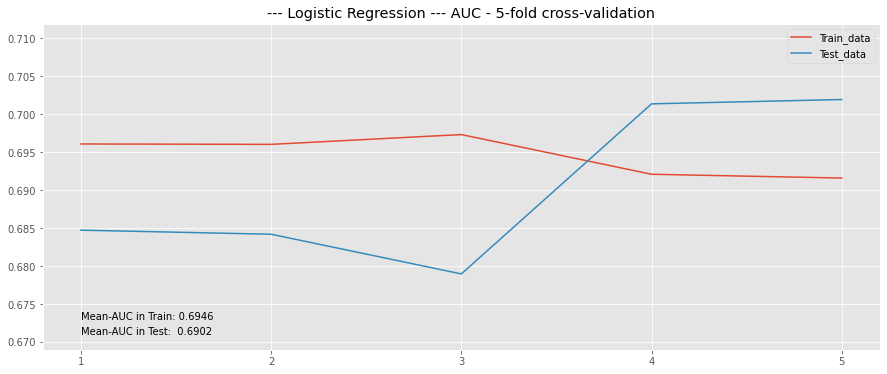

In [9]:
train_lr, test_lr = cv_results_lr['train_roc_auc'], cv_results_lr['test_roc_auc']
means_lr = (train_lr.mean(), test_lr.mean())
## Para los límites en el eje y
values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
##
plt.plot(cv_results_lr['train_roc_auc'], label='Train_data')
plt.plot(cv_results_lr['test_roc_auc'], label = 'Test_data')
plt.title('--- Logistic Regression --- AUC - 5-fold cross-validation')
plt.legend()
plt.text(0, min_y + 4e-03, f'Mean-AUC in Train: {means_lr[0]:.4f}')
plt.text(0, min_y + 2e-03, f'Mean-AUC in Test:  {means_lr[1]:.4f}')
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5),np.arange(1,6))
plt.show()

## ***Modelo Naive Bayes.***

In [10]:
## Las variables deben entrar categóricas. X es pd.DatatFrame donde están las columnas de las variables
## explicativas and y es la variable target.
def nb_classifier_proba(X, y, X_predict):
    #################################### Preparamos la Data #########################################
    X, y, X_predict = X.copy(), y.copy(), X_predict.copy()
    probas = y.value_counts(normalize = True)
    proba_no_moroso, proba_moroso  = probas[0], probas[1]
    X["annual_inc_log"] = np.log10(X["annual_inc"])
    X["loan_amnt_sqrt"] = np.sqrt(X["loan_amnt"])
    X_predict["annual_inc_log"] = np.log10(X_predict["annual_inc"])
    X_predict["loan_amnt_sqrt"] = np.sqrt(X_predict["loan_amnt"])
    ################################# Entrenamos el modelo ###########################################
    label_encoder = LabelEncoder()
    for column in X.select_dtypes("category"):
        X[column] = label_encoder.fit_transform(X[column])    
    ### Ajustamos el modelo para variables continuas.
    gnb = GaussianNB()
    Xcont = X[["annual_inc_log","loan_amnt_sqrt","int_rate"]]
    fit_model_cont = gnb.fit(Xcont, y)    
    ## Ajustamos el modelo para variables categóricas.
    mnb = MultinomialNB()
    Xcat = X[["verification_status", "emp_length", "home_ownership","purpose","term","grade"]]
    fit_model_cat = mnb.fit(Xcat, y)
    ################################## predict del modelo  ############################################
    for column in X_predict.select_dtypes("category"):
        X_predict[column] = label_encoder.fit_transform(X_predict[column])
    Xcont_predict = X_predict[["annual_inc_log","loan_amnt_sqrt","int_rate"]]   
    Xcat_predict = X_predict[["verification_status", "emp_length", "home_ownership","purpose",
                              "term","grade"]]
    cont_probas = gnb.predict_proba(Xcont_predict)  
    cat_probas = mnb.predict_proba(Xcat_predict)
    proba_predict = np.multiply(cont_probas, cat_probas)/np.array([proba_moroso, proba_no_moroso])
    
    return proba_predict[:,1]

In [11]:
predict_proba_nb = nb_classifier_proba(X=df.drop(columns=["loan_status"]),
                                       y=df["loan_status"],
                                       X_predict=df.drop(columns=["loan_status"]))
##
roc_auc_nb = roc_auc_score(y, predict_proba_nb)
print(f'Naive-Bayes AUC = {roc_auc_nb:.4f}')

Naive-Bayes AUC = 0.6623


In [12]:
## X en las mismas condiciones de la función --->  nb_classifier_proba
def cv_auc_nb(X, y,nFolds):
    cv = StratifiedKFold(n_splits = nFolds)
    aucs_train, aucs_test = [], []
    for train, test in cv.split(X,y):
        probas_train = nb_classifier_proba(X.iloc[train], y.iloc[train],X.iloc[train])
        probas_test = nb_classifier_proba(X.iloc[train], y.iloc[train], X.iloc[test])
        ###
        auc_train = roc_auc_score(y.iloc[train], probas_train)
        aucs_train.append(auc_train)
        auc_test = roc_auc_score(y.iloc[test], probas_test)
        aucs_test.append(auc_test)
    return np.array(aucs_train), np.array(aucs_test)

In [13]:
X_nb = df.copy()
y = X_nb["loan_status"]
X_nb = X_nb.drop(columns = ["loan_status"])
##
train, test = cv_auc_nb(X_nb,y,5)

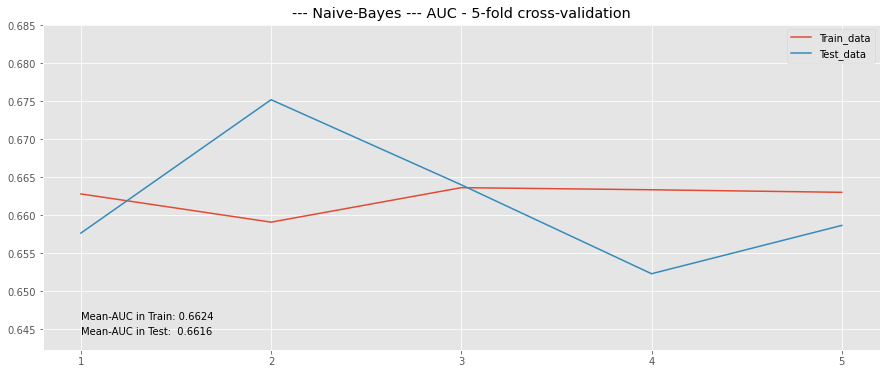

In [14]:
means_nb = (train.mean(), test.mean())
## Para los límites en el eje y
values_aucs_nb = np.concatenate((train, test), axis=None)
min_y, max_y = values_aucs_nb.min()-0.01 , values_aucs_nb.max()+ 0.01
##
plt.plot(train, label = "Train_data")
plt.plot(test, label = "Test_data")
plt.title("--- Naive-Bayes --- AUC - 5-fold cross-validation")
plt.legend()
plt.text(0, min_y + 4e-03, f'Mean-AUC in Train: {means_nb[0]:.4f}')
plt.text(0, min_y + 2e-03, f'Mean-AUC in Test:  {means_nb[1]:.4f}')
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5),np.arange(1,6))
plt.show()

## ***Modelo Random Forrest.***

In [15]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=123)
model_rf.fit(X_train,y_train)
##
predict_proba_rf = model_rf.predict_proba(X_train)[:,1]
roc_auc_rf = roc_auc_score(y_train, predict_proba_rf)
print(f'Random Forrest AUC = {roc_auc_rf:.4f}')

Random Forrest AUC = 0.6884


In [16]:
### cross_validate en RandomForrest.
np.random.seed(123)                                           ## Semilla para comparar modelos.
cv_results_rf = cross_validate(model_rf, X_train, y_train, cv = 5, 
                               scoring = ("roc_auc","accuracy"),
                               return_train_score = True,)

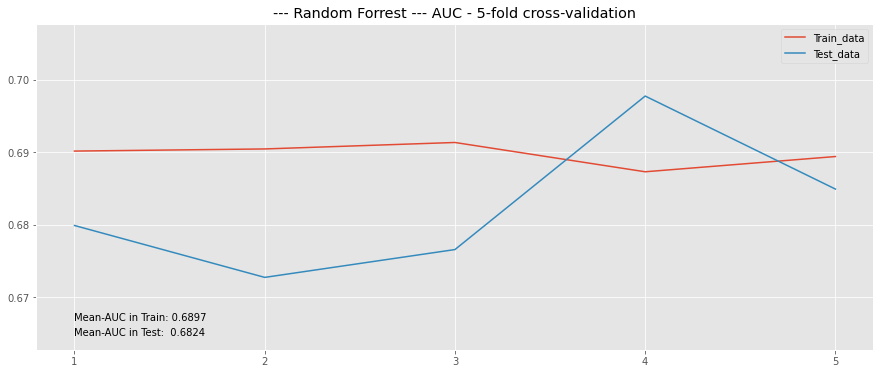

In [17]:
train_lr, test_lr = cv_results_rf['train_roc_auc'], cv_results_rf['test_roc_auc']
## Para los límites en el eje y
values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
means_rf = (train_lr.mean(), test_lr.mean())
##
plt.plot(cv_results_rf['train_roc_auc'], label = 'Train_data')
plt.plot(cv_results_rf['test_roc_auc'], label = 'Test_data')
plt.title('--- Random Forrest --- AUC - 5-fold cross-validation')
plt.legend()
plt.text(0, min_y + 4e-03, f'Mean-AUC in Train: {means_rf[0]:.4f}')
plt.text(0, min_y + 2e-03, f'Mean-AUC in Test:  {means_rf[1]:.4f}')
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5),np.arange(1,6))
plt.show()

## ***Búsqueda de parámetros.***

Vamos a hacer uso de: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)[source]¶

In [18]:
from sklearn.model_selection import RandomizedSearchCV
##
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
##
params = {"n_estimators":[50,100,150,200], "max_depth":[3,4,5,6], "criterion":["gini","entropy"]}
clf = RandomizedSearchCV(rf_model, params, random_state= 0, scoring="roc_auc", cv =5,
                         n_iter = 10, n_jobs=-1)
##
search = clf.fit(X_train, y_train)
search.best_params_

{'n_estimators': 150, 'max_depth': 5, 'criterion': 'entropy'}

In [19]:
rf_best_model = RandomForestClassifier(n_estimators = 100, max_depth = 6, criterion="gini")
rf_best_model.fit(X_train,y_train)
##
predict_proba_rf_best_model = rf_best_model.predict_proba(X_train)[:,1]
roc_auc_rf_best_model = roc_auc_score(y_train, predict_proba_rf_best_model)
print(f'Random Forrest AUC = {roc_auc_rf_best_model:.4f}')

Random Forrest AUC = 0.7090


In [20]:
cv_results_rf_fino = cross_validate(rf_best_model, X_train, y_train, cv = 5,
                                    scoring = ('roc_auc','accuracy'),
                                    return_train_score = True,)

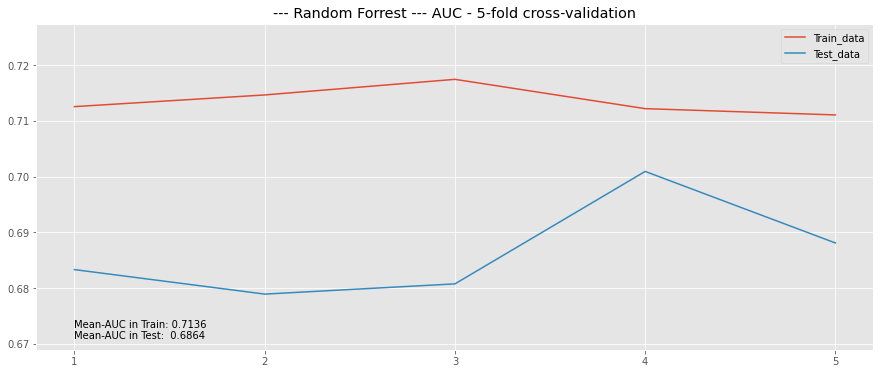

In [21]:
train_lr, test_lr = cv_results_rf_fino['train_roc_auc'], cv_results_rf_fino['test_roc_auc']
## Para los límites en el eje y
values_aucs_lr = np.concatenate((train_lr, test_lr), axis=None)
min_y, max_y = values_aucs_lr.min() -0.01 , values_aucs_lr.max()+ 0.01
means_rf = (train_lr.mean(), test_lr.mean())
##
plt.plot(cv_results_rf_fino['train_roc_auc'], label = 'Train_data')
plt.plot(cv_results_rf_fino['test_roc_auc'], label = 'Test_data')
plt.title('--- Random Forrest --- AUC - 5-fold cross-validation')
plt.legend()
plt.text(0, min_y + 4e-03, f'Mean-AUC in Train: {means_rf[0]:.4f}')
plt.text(0, min_y + 2e-03, f'Mean-AUC in Test:  {means_rf[1]:.4f}')
plt.ylim(min_y, max_y)
plt.xticks(np.arange(0,5),np.arange(1,6))
plt.show()

### ***Test en muestra nunca observada***

In [22]:
predict_proba_lr_train = model_lr.predict_proba(X_train)[:,1] 
predict_proba_lr_test = model_lr.predict_proba(X_test)[:,1] 
print(f'Logistic Regression AUC TRAIN = {roc_auc_score(y_train, predict_proba_lr_train):.4f}')
print(f'Logistic Regression AUC TEST = {roc_auc_score(y_test, predict_proba_lr_test):.4f}')

Logistic Regression AUC TRAIN = 0.6942
Logistic Regression AUC TEST = 0.6822


In [23]:
predict_proba_rf_train = rf_best_model.predict_proba(X_train)[:,1]
predict_proba_rf_test = rf_best_model.predict_proba(X_test)[:,1]
print(f'Random Forrest AUC TRAIN = {roc_auc_score(y_train, predict_proba_rf_train):.4f}')
print(f'Random Forrest AUC TEST = {roc_auc_score(y_test, predict_proba_rf_test):.4f}')

Random Forrest AUC TRAIN = 0.7090
Random Forrest AUC TEST = 0.6855
